In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [84]:
image = np.asarray(Image.open('china-original.png').convert('L'))

In [85]:
def adjust_brightness(image, brightness):
    return np.clip(image * brightness**4, 0, 255).astype(np.uint8)

brightness_slider = widgets.FloatSlider(
    value=1.0,
    min=0,
    max=2,
    step=0.1,
    description='Brightness:',
    continuous_update=True
)

def update_brightness(brightness):
    adjusted_image = adjust_brightness(image, brightness)
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.imshow(adjusted_image,cmap='gray')
    ax1.axis('off')
    ax2.hist(adjusted_image.ravel(),255,density=1,range=(0,255))
    ax2.set_title('image histogram')
    plt.tight_layout()
    plt.show()

widgets.interact(update_brightness, brightness=brightness_slider)

interactive(children=(FloatSlider(value=1.0, description='Brightness:', max=2.0), Output()), _dom_classes=('wi…

<function __main__.update_brightness(brightness)>

In [86]:
def adjust_contrast(image, contrast):    
    return np.clip(image + (image - np.mean(image)) * np.sin(contrast), 0, 255).astype(np.uint8)

contrast_slider = widgets.FloatSlider(
    value=0,
    min=-1,
    max=1,
    step=0.1,
    description='Contrast:',
    continuous_update=True
)

def update_contrast(contrast):
    adjusted_image = adjust_contrast(image, contrast)
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.imshow(adjusted_image, cmap='grey')
    ax1.axis('off')
    ax2.hist(adjusted_image.ravel(),255,density=1,range=(0,255))
    ax2.set_title('image histogram')
    plt.tight_layout()
    plt.show()

widgets.interact(update_contrast, contrast=contrast_slider)

interactive(children=(FloatSlider(value=0.0, description='Contrast:', max=1.0, min=-1.0), Output()), _dom_clas…

<function __main__.update_contrast(contrast)>

### Windowing can enahnce part of an image.(If it is recognizable from it's histogram. e.g, the bottom right tree)
### 10 - 30 is a decent range.

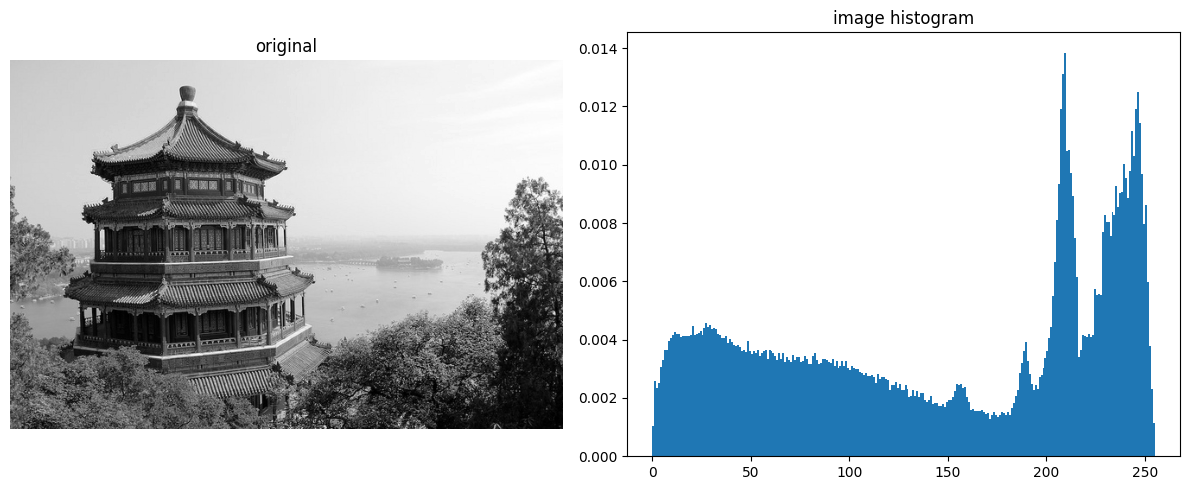

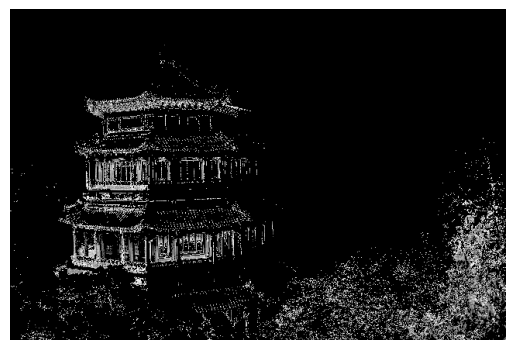

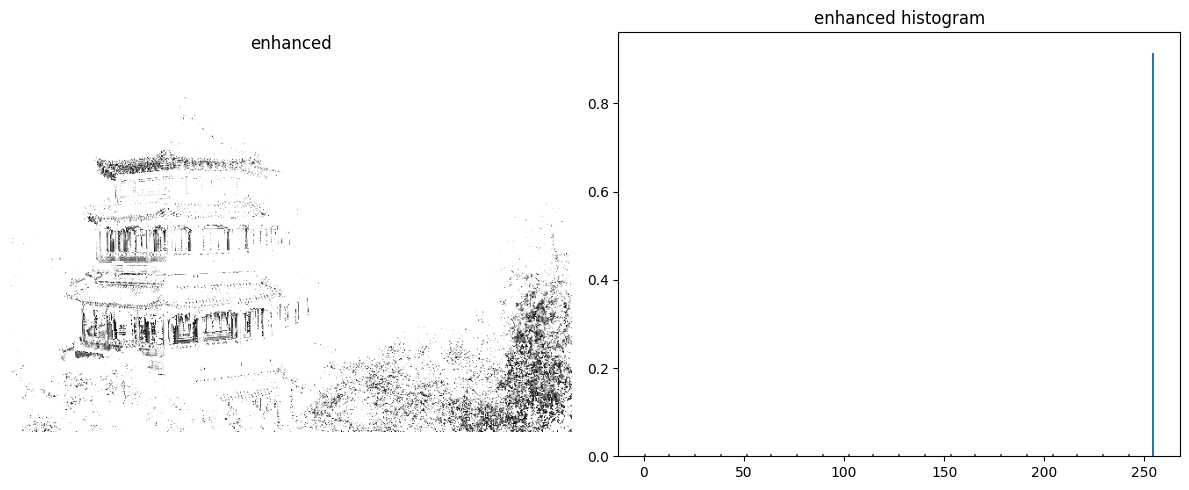

In [87]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(image, cmap='grey')
ax1.set_title('original')
ax1.axis('off')
ax2.set_title('image histogram')
ax2.hist(image.ravel(),255,density=1,range=(0,255))
plt.tight_layout()
plt.show()

temp = image.copy()
temp[(10 > temp) | (temp > 30)] = 0
plt.imshow(temp, cmap='grey')
plt.axis('off')
plt.show()

# Seems like 10-30 range captures the bottom right tree

enhanced_image = np.clip(255/(30 - 10) * (image - 10),0,255)
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(enhanced_image, cmap='grey')
ax1.set_title('enhanced')
ax1.axis('off')
ax2.set_title('enhanced histogram')
ax2.hist(enhanced_image.ravel(),255,density=1,range=(0,255))
plt.tight_layout()
plt.show()


### Suppose we want to enhance a darkened image.
### Windowing solves the problem by expanding the collapsed histogram.

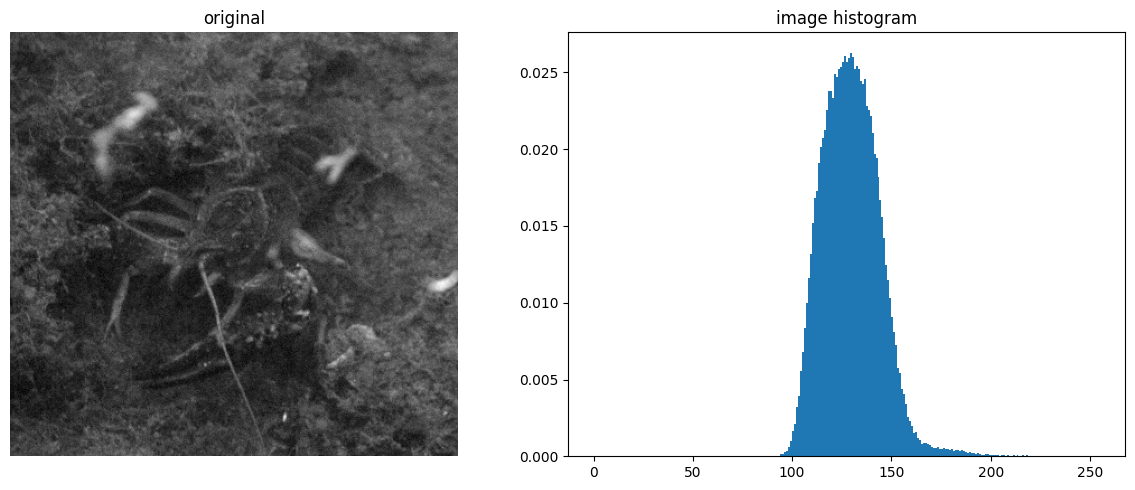

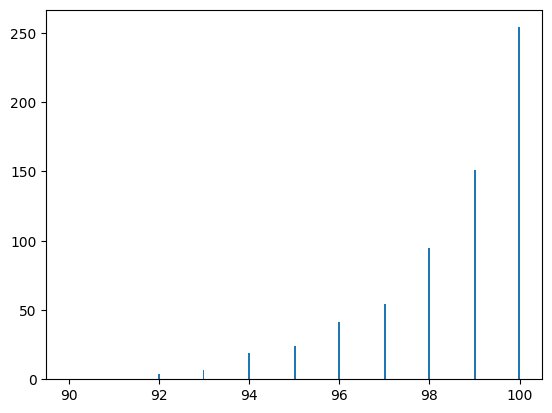

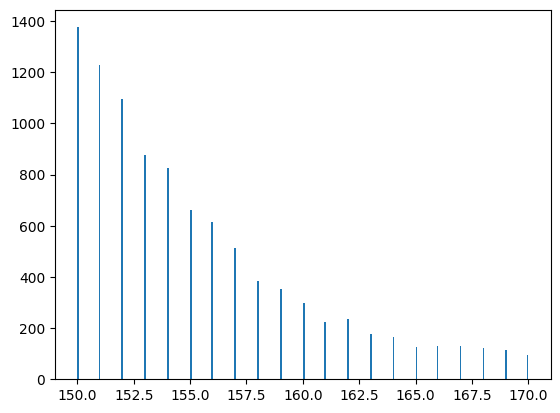

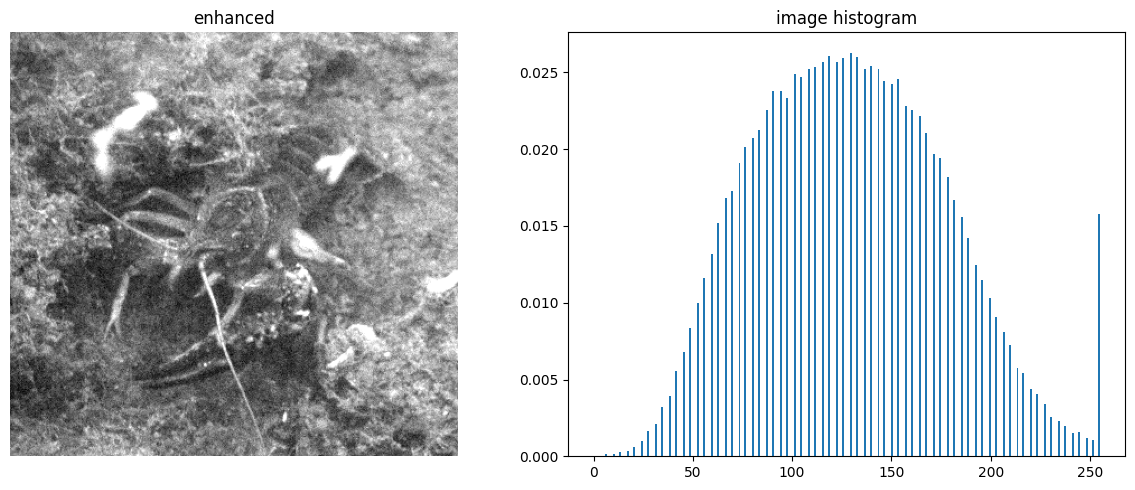

In [4]:
bad_image1 = plt.imread('crayfish.jpg')
enhanced_image = np.clip((bad_image1 - 92) / 73 * 255, 0, 255).astype(np.uint8)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(bad_image1, cmap='grey')
ax1.set_title('original')
ax1.axis('off')
ax2.set_title('image histogram')
ax2.hist(bad_image1.ravel(),255,density=1,range=(0,255))
plt.tight_layout()
plt.show()
plt.hist(bad_image1.ravel(),256,[90,100])
plt.show()
plt.hist(bad_image1.ravel(),256,[150,170])
plt.show()
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(enhanced_image,cmap='gray')
ax1.set_title('enhanced')
ax1.axis('off')
ax2.set_title('image histogram')
ax2.hist(enhanced_image.ravel(),255,density=1,range=(0,255))
plt.tight_layout()
plt.show()


### Suppose we want to enhance a high contrast image. Windowing will not work since the original histogram range is almost full.
### Histogram Equalization will save the day!

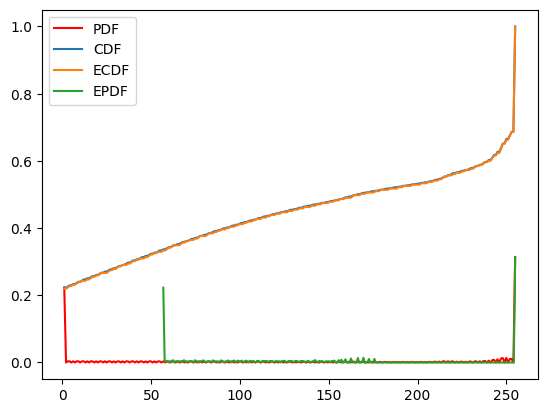

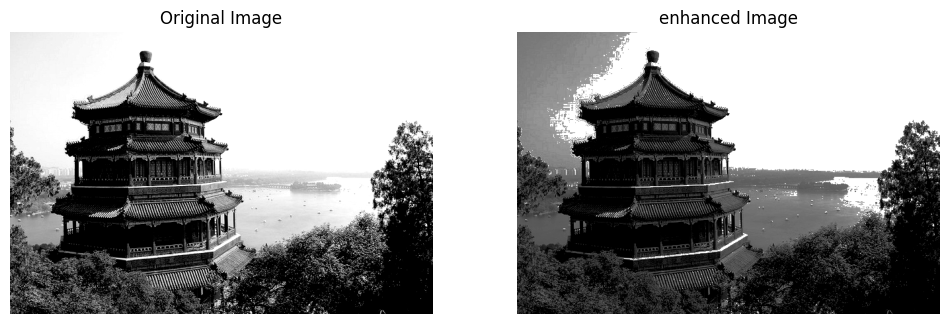

In [89]:
bad_image2 = adjust_contrast(image, .7)
count, bins_count = np.histogram(bad_image2.ravel(), bins=256)
pdf = count.astype(np.float32) / bad_image2.size
cdf = np.cumsum(pdf)
ecdf = np.floor(255 * cdf)
ecdf_image = ecdf[bad_image2.ravel()]
ecdf_image = np.reshape(ecdf_image, bad_image2.shape)
ecdf_count, ecdf_bins_count = np.histogram(ecdf_image, bins=256)

plt.plot(bins_count[1:], pdf, color="red", label="PDF") 
plt.plot(bins_count[1:], cdf, label="CDF")
plt.plot(bins_count[1:], ecdf/255, label="ECDF")
plt.plot(ecdf_bins_count[1:], ecdf_count/bad_image2.size, label="EPDF")
plt.legend()
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.axis('off')
plt.imshow(bad_image2, cmap='gray')
plt.subplot(1,2,2)
plt.title("enhanced Image")
plt.imshow(ecdf_image, cmap='gray')
plt.axis('off')
plt.show()
